In [23]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


pd.set_option('display.max_colwidth', 3000)
pd.set_option("display.max_rows", 100000)


In [24]:
import sklearn
sklearn.__version__

'0.23.2'

In [25]:
def read_pickle_files(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)


def plot_roc_curve(class_dict, y_preds, y_truth, get_auc=True):
    plt.figure(figsize=(12, 9))
    auc_dict = dict()
    for (idx, c_label) in enumerate(class_dict.values()):
        fpr, tpr, thresholds = roc_curve(y_truth.iloc[:, idx].astype(int), y_preds[:, idx])
        plt.plot(fpr, tpr, label="{}: [AUC: {:.03f}]".format(c_label, auc(fpr, tpr)))
        auc_dict[c_label] = auc(fpr, tpr)
    # plt.legend()
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # fig.savefig('trained_net.png')
    plt.show()

    return auc_dict


def save_model(model, filepath):
    with open(filepath, "wb") as f:
        pickle.dump(model, f)
        
def load_model(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)
        
        
# def data_scaler(df):
#     scaler = StandardScaler()
#     df = pd.DataFrame(scaler.fit_transform(df))
#     return df

In [26]:
print("Reading Features Data from Drive...")
test_metadata = pd.read_csv(r"D:\Northeastern courses\CS 5100\Project\features\manual_features_test.csv")
train_metadata = pd.read_csv(r"D:\Northeastern courses\CS 5100\Project\features\manual_features_train.csv")
valid_metadata = pd.read_csv(r"D:\Northeastern courses\CS 5100\Project\features\manual_features_valid.csv")

features_df = pd.concat([train_metadata,test_metadata,valid_metadata])
print(features_df.shape)
del train_metadata
del test_metadata
del valid_metadata
# print("Dropping Unnecessary Columns")
# features_df.drop(columns=["disease_vec", "image_index"], axis=1, inplace=True)
print("Done!")

Reading Features Data from Drive...
(112120, 830)
Done!


In [5]:
# print("Scaling Data...")
# features_df = data_scaler(features_df)
# print("Done!")

In [27]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,820,821,822,823,824,825,826,827,828,829
0,0.144319,0.190131,0.123659,0.198999,0.138993,0.177944,0.116892,0.184802,0.931036,0.912238,...,0.002386,-0.024689,0.009111,-0.005964,0.003828,0.007751,0.001331,0.056554,-0.024926,0.121842
1,0.219631,0.287860,0.142497,0.283014,0.184397,0.235697,0.131126,0.233506,0.911136,0.887101,...,0.003973,0.008902,-0.002839,0.006254,0.000983,-0.004631,0.013774,-0.010777,-0.004651,0.012219
2,0.296525,0.438839,0.265315,0.443061,0.246517,0.325343,0.212464,0.334272,0.881268,0.847385,...,0.021491,-0.056614,0.028483,-0.010287,-0.009111,-0.030841,0.036137,-0.063455,0.055403,-0.057903
3,0.365511,0.527680,0.290339,0.502001,0.256766,0.328038,0.195648,0.321543,0.879924,0.851711,...,-0.078504,0.011956,0.015926,0.023873,0.024170,0.028598,0.011067,-0.004115,-0.021362,-0.176931
4,0.233544,0.313720,0.193085,0.324720,0.213965,0.267631,0.175709,0.275332,0.894963,0.870750,...,-0.135848,0.010583,-0.004230,-0.001682,-0.045882,0.029407,-0.020292,-0.068086,-0.257654,0.191388


In [28]:
print("Reading Class Dict...")
class_dict = read_pickle_files(r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\class_dict_wo_NF.pkl")
classes = list(class_dict.values())
print("Done!")

Reading Class Dict...
Done!


In [29]:
classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [30]:
print("Reading Metadata...")
metadata = pd.read_csv(r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\final_df_all_images_wo_NF_labels.csv")
print("Extracting Disease Label Columns...")
labels_df = metadata[classes]
del metadata
print("Done!")

Reading Metadata...
Extracting Disease Label Columns...
Done!


In [31]:
labels_df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [32]:
test_split = 0.01
train_split = 1-test_split
print("Splitting Data into Train ({}%) and Test ({}%) ...".format(train_split*100, test_split*100))
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=test_split, random_state=101, shuffle=True)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
print("Done!")

Splitting Data into Train (99.0%) and Test (1.0%) ...
Done!


## 1. LOGISTIC REGRESSION

In [33]:
print("Fitting Logistic Regression Model with OVR Classifier...")
start = time.time()
ovr_logistic_regression = OneVsRestClassifier(LogisticRegression(random_state=7,
                                                                 verbose=0,
                                                                 max_iter=200))


ovr_logistic_regression.fit(X_train, y_train)
print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Logistic Regression Model with OVR Classifier...


D:\softwares\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\softwares\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Done!
Time Taken: 271.00335


D:\softwares\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\ovr_logistic_regression_manual_features.sav"
save_model(ovr_logistic_regression, filepath)

In [81]:
filepath = r"E:\ARSH\NEU\Fall 2021\CS 5100\Projects\NIH_Disease_Detection\ML Models and Outputs\ovr_logistic_regression2.sav"
ovr_logistic_regression = load_model(filepath)

Evaluating Model on Train Set...
Creating ROC Curve and computing AUC...


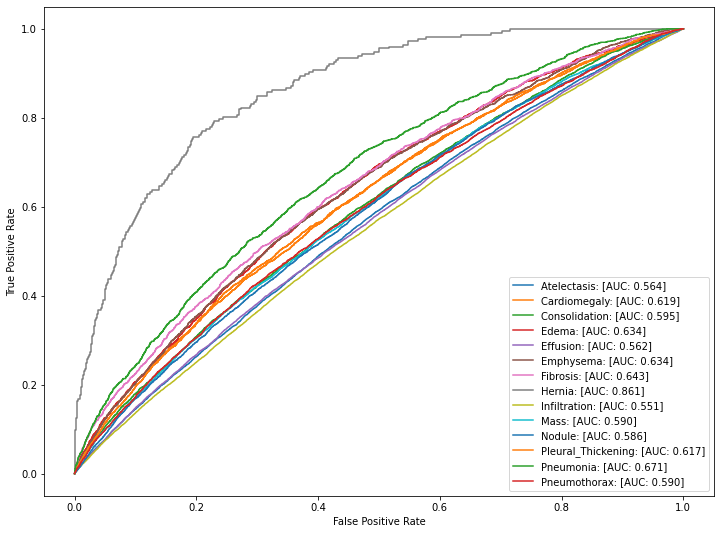

Done!


In [35]:
print("Evaluating Model on Train Set...")
y_preds = ovr_logistic_regression.predict_proba(X_train)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_train, get_auc=True)
print("Done!")

Evaluating Model on Test Set...
Creating ROC Curve and computing AUC...


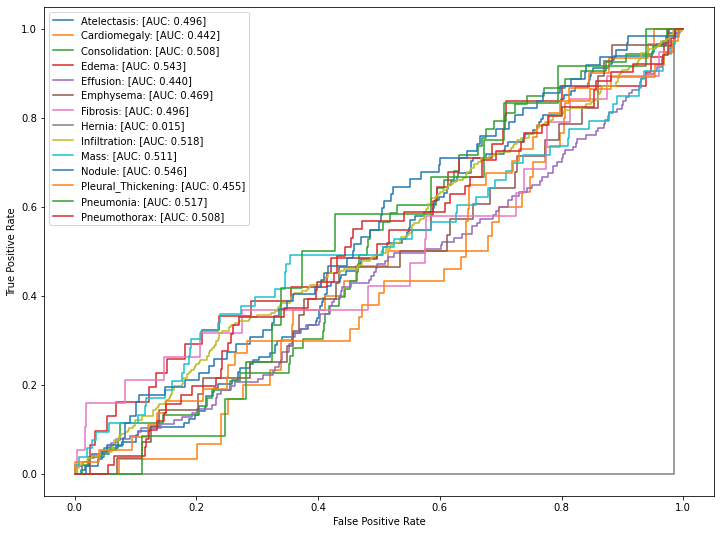

Done!


In [36]:
print("Evaluating Model on Test Set...")
y_preds = ovr_logistic_regression.predict_proba(X_test)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
print("Done!")


In [37]:
auc_dict

{'Atelectasis': 0.4958925090504038,
 'Cardiomegaly': 0.4420940170940171,
 'Consolidation': 0.5079513564078578,
 'Edema': 0.5425623133556075,
 'Effusion': 0.43986903091380697,
 'Emphysema': 0.4692151997910682,
 'Fibrosis': 0.49577706732833904,
 'Hernia': 0.015165031222123093,
 'Infiltration': 0.5182349665924275,
 'Mass': 0.5113225197239529,
 'Nodule': 0.5463177115033475,
 'Pleural_Thickening': 0.45549881678913934,
 'Pneumonia': 0.5167417417417417,
 'Pneumothorax': 0.5081012797275773}

In [38]:
np.array(list(auc_dict.values())).mean()

0.4617673972315292

## 2. DECISION TREE

In [90]:
print("Fitting Decision Tree Classifier...")
start = time.time()
dtree = DecisionTreeClassifier(criterion="gini",
                               random_state=7,
                               min_samples_leaf=70,
                               min_samples_split= 70,
                               max_depth=500)
dtree.fit(X_train, y_train)

filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\decision_tree_classifier_manual_features_v2.sav"
save_model(dtree, filepath)

print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Decision Tree Classifier...
Done!
Time Taken: 479.60501


In [86]:
# filepath = r"E:\ARSH\NEU\Fall 2021\CS 5100\Projects\NIH_Disease_Detection\ML Models and Outputs\decision_tree_classifier_v4_md1k.sav"
# dtree = load_model(filepath)

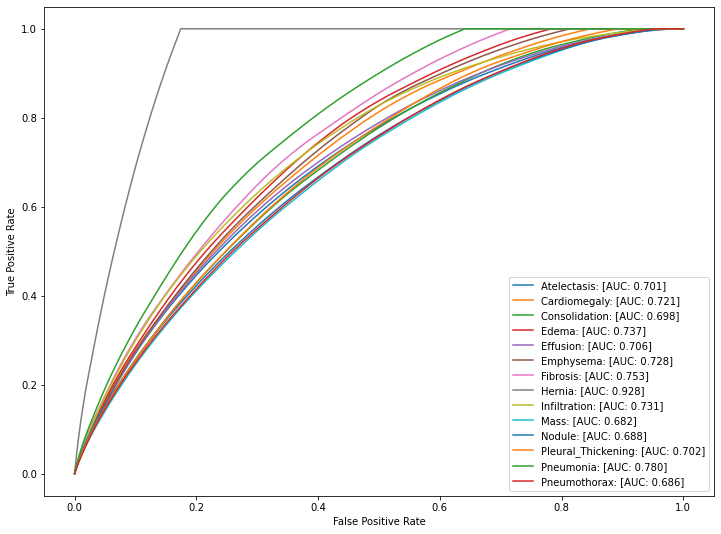

Done!


In [95]:
y_preds = dtree.predict_proba(X_train)
y_pred = np.array(y_preds)
y_preds = np.transpose([pred for pred in y_pred])
auc_dict = plot_roc_curve(class_dict, y_preds[1, :], y_train, get_auc=True)
print("Done!")

In [96]:
np.array(list(auc_dict.values())).mean()

0.731474961738266

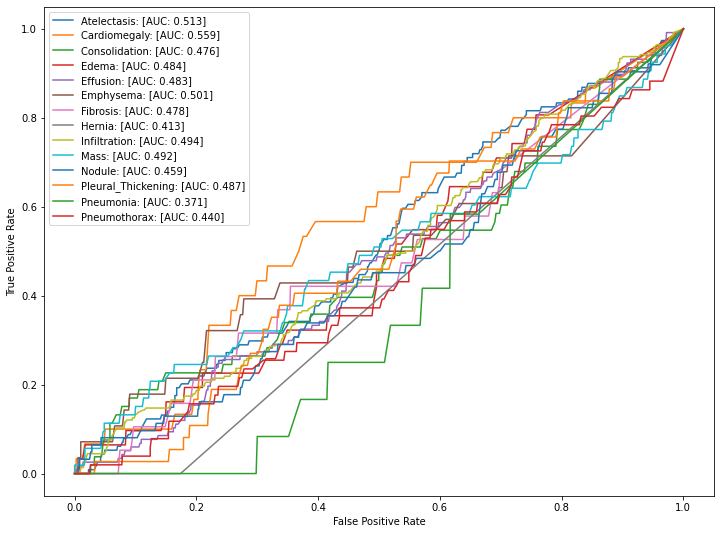

Done!


In [97]:
y_preds = dtree.predict_proba(X_test)
y_pred = np.array(y_preds)
y_preds = np.transpose([pred for pred in y_pred])
auc_dict = plot_roc_curve(class_dict, y_preds[1, :], y_test, get_auc=True)
print("Done!")

In [98]:
np.array(list(auc_dict.values())).mean()

0.4749913612735022

## 3. RANDOM FOREST


In [41]:
print("Fitting Random Forest Classifier...")
start = time.time()
rfc = RandomForestClassifier(max_features='sqrt',
                             n_estimators=50,
                             random_state=7)
rfc.fit(X_train, y_train)

filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\random_forest_classifier_manual_features.sav"
save_model(rfc, filepath)

print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Random Forest Classifier...
Done!
Time Taken: 2993.05248


Evaluating Model on Test Set...
Creating ROC Curve and computing AUC...


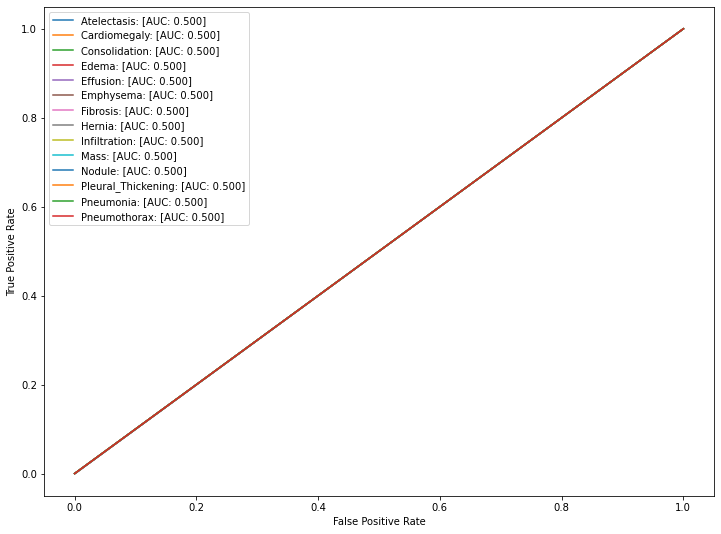

Done!


In [56]:
print("Evaluating Model on Test Set...")
y_preds = rfc.predict_proba(X_test)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
print("Done!")

## 4. NAIVE BAYES (BERNOULLI)

In [44]:
from sklearn.naive_bayes import BernoulliNB

print("Fitting Bernoulli Naive Bayes with OVR Classifier...")
start = time.time()
bernoulliNB = OneVsRestClassifier(BernoulliNB())


bernoulliNB.fit(X_train, y_train)
print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Bernoulli Naive Bayes with OVR Classifier...
Done!
Time Taken: 25.74255


In [45]:
filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\bernoulliNB_manual_features.sav"
save_model(bernoulliNB, filepath)

In [89]:
filepath = r"E:\ARSH\NEU\Fall 2021\CS 5100\Projects\NIH_Disease_Detection\ML Models and Outputs\bernoulliNB.sav"
bernoulliNB = load_model(filepath)

Evaluating Model on Train Set...
Creating ROC Curve and computing AUC...


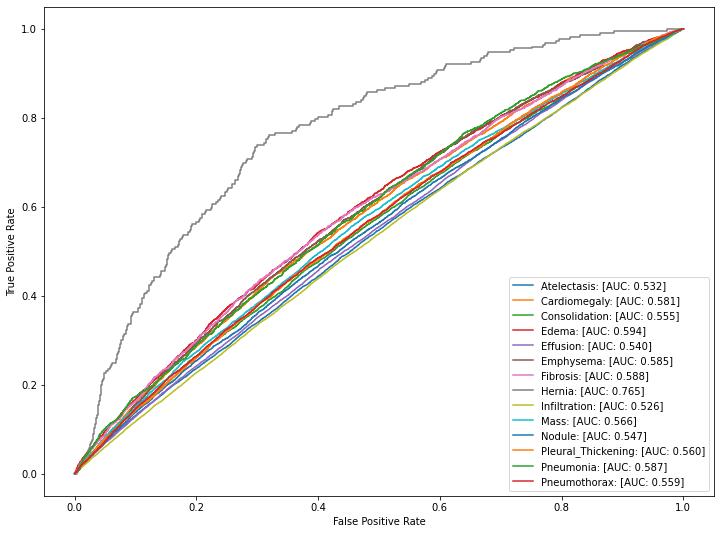

Done!


In [46]:
print("Evaluating Model on Train Set...")
y_preds = bernoulliNB.predict_proba(X_train)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_train, get_auc=True)
print("Done!")


Evaluating Model on Test Set...
Creating ROC Curve and computing AUC...


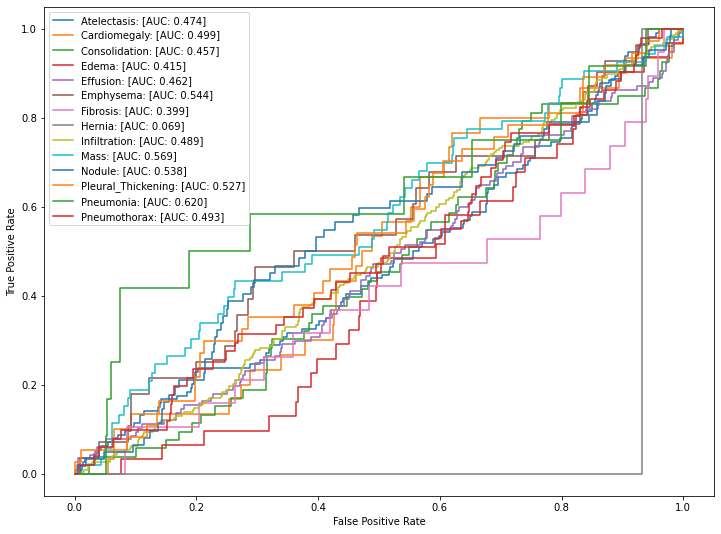

Done!


In [47]:
print("Evaluating Model on Test Set...")
y_preds = bernoulliNB.predict_proba(X_test)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
print("Done!")


In [48]:
np.array(list(auc_dict.values())).mean()

0.4682639244311074

## 5. NAIVE BAYES (GAUSSIAN)

In [49]:
from sklearn.naive_bayes import GaussianNB

print("Fitting Bernoulli Naive Bayes with OVR Classifier...")
start = time.time()
gaussianNB = OneVsRestClassifier(GaussianNB())


gaussianNB.fit(X_train, y_train)
print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Bernoulli Naive Bayes with OVR Classifier...
Done!
Time Taken: 22.11449


In [50]:
filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\gaussianNB_manual_features.sav"
save_model(gaussianNB, filepath)

Evaluating Model on Train Set...
Creating ROC Curve and computing AUC...


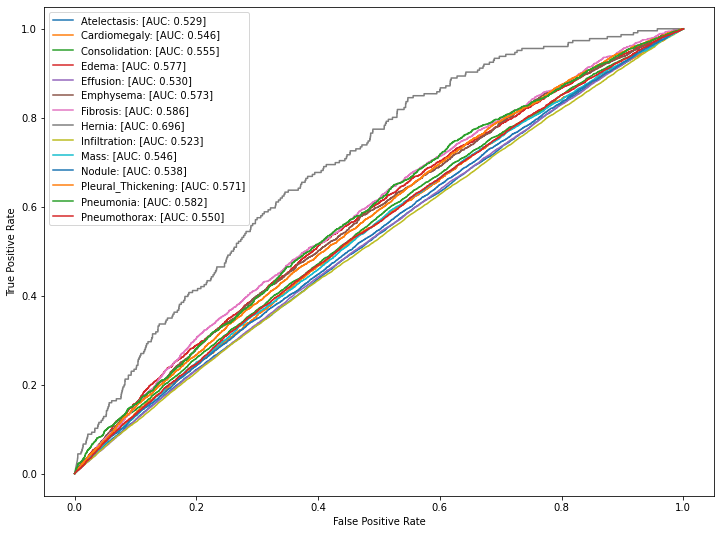

Done!


In [51]:
print("Evaluating Model on Train Set...")
y_preds = gaussianNB.predict_proba(X_train)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_train, get_auc=True)
print("Done!")

Evaluating Model on Test Set...
Creating ROC Curve and computing AUC...


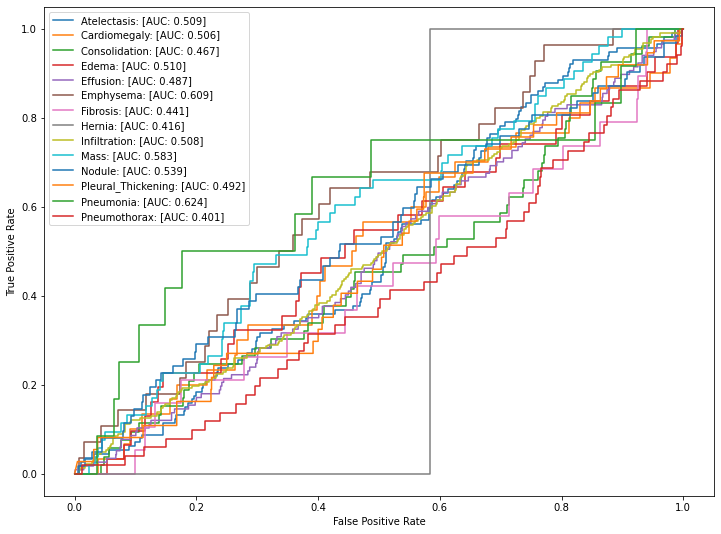

Done!


In [52]:
print("Evaluating Model on Test Set...")
y_preds = gaussianNB.predict_proba(X_test)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
print("Done!")


In [53]:
np.array(list(auc_dict.values())).mean()

0.5063969074800051

## 6. Extra Trees

In [149]:
print("Fitting Extra Trees Classifier...")
from sklearn.ensemble import ExtraTreesClassifier
start = time.time()
etc3 = ExtraTreesClassifier(n_jobs=-1,random_state=7, max_features='sqrt', n_estimators= 300, max_depth=300, criterion='gini',
                           min_samples_split=500, min_samples_leaf = 700)

etc3.fit(X_train, y_train)
print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\extratrees_manual_features.sav"
save_model(etc3, filepath)

Fitting Extra Trees Classifier...
Done!
Time Taken: 59.72592


Evaluating Model on Train Set...
Creating ROC Curve and computing AUC...


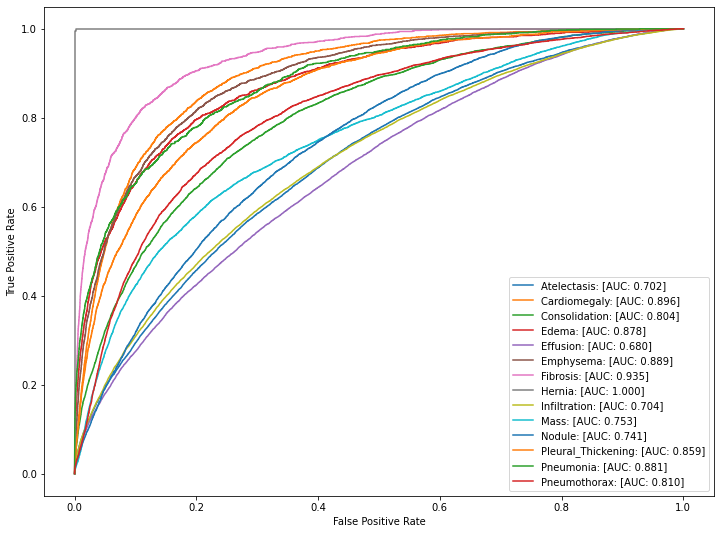

Done!


In [150]:
print("Evaluating Model on Train Set...")
y_preds = etc3.predict_proba(X_train)
y_pred = np.array(y_preds)
ypreds = np.transpose([pred for pred in y_pred])
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, ypreds[1,:], y_train, get_auc=True)
print("Done!")

In [151]:
np.array(list(auc_dict.values())).mean()

0.8237036051243853

Evaluating Model on Test Set...
Creating ROC Curve and computing AUC...


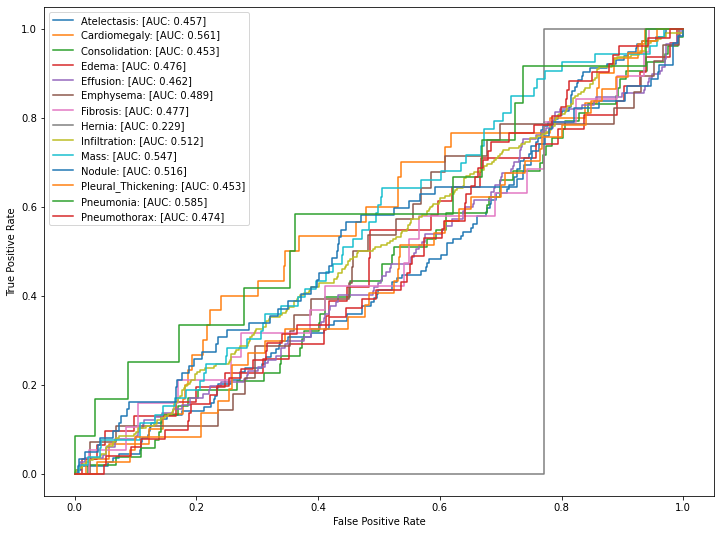

Done!


In [152]:
print("Evaluating Model on Test Set...")
y_preds = etc3.predict_proba(X_test)
y_pred = np.array(y_preds)
ypreds = np.transpose([pred for pred in y_pred])
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, ypreds[1,:], y_test, get_auc=True)
print("Done!")

In [153]:
np.array(list(auc_dict.values())).mean()

0.478024160305295